# Semantic Segmentation of Aerial Imagery with Raster Vision 
## Part 7: Evaluating training performance and visualizing predictions

This tutorial series walks through an example of using [Raster Vision](https://rastervision.io/) to train a deep learning model to identify buildings in satellite imagery.</br>

*Primary Libraries and Tools*:

|Name|Description|Link|
|-|-|-|
| `Raster Vision ` | Library and framework for geospatial semantic segmentation, object detection, and chip classification with python| https://rastervision.io/ |
| `Singularity` | Containerization software that allows for transportable and reproducible software | https://docs.sylabs.io/guides/3.5/user-guide/introduction.html |
| `pandas` | Dataframes and other datatypes for data analysis and manipulation | https://pandas.pydata.org/ |
| `geopandas` | Extends datatypes used by pandas to allow spatial operations on geometric types | https://geopandas.org/en/stable/ |
| `rioxarray` | Data structures and routines for working with gridded geospatial data | https://github.com/corteva/rioxarray |
| `plotnine` | A plotting library for Python modeled after R's [ggplot2](https://ggplot2.tidyverse.org/) | https://plotnine.readthedocs.io/en/v0.12.3/ |
| `pathlib` | A Python library for handling files and paths in the filesystem | https://docs.python.org/3/library/pathlib.html |

*Prerequisites*:
  * Basic understanding of navigating the Linux command line, including navigating among directories and editing text files
  * Basic python skills, including an understanding of object-oriented programming, function calls, and basic data types
  * Basic understanding of shell scripts and job scheduling with SLURM for running code on Atlas
  * A SCINet account for running this tutorial on Atlas
  * **Completion of tutorial parts 1-6 of this series**

*Tutorials in this Series*:
  * 1\. **Tutorial Setup on SCINet**
  * 2\. **Overview of Deep Learning for Imagery and the Raster Vision Pipeline**
  * 3\. **Constructing and Exploring the Singularity Image**
  * 4\. **Exploring the dataset and problem space**
  * 5\. **Overview of Raster Vision Model Configuration and Setup**
  * 6\. **Breakdown of Raster Vision Code Version 1**
  * 7\. **Evaluating training performance and visualizing predictions <span style="color: red;">_(You are here)_</span>**

<a id='step_7'></a>
## Evaluating Training Performance and Visualizing Predictions

Once training is complete, it is important to examine the metrics Raster Vision gathered during the training process. These metrics can help you evaluate whether the training process succeeded and how well your model performs. Model evaluation and metrics are rich topics which we will not have time to discuss in much detail for this tutorial. We will visualize several key metrics that Raster Vision logged during the training process. This will help us assess how well our training worked.

First, we will look at the confusion matrix. This represents the proportion of true positive (TP), true negative (TN), false positive (FN), and false positive (FP) predictions in our validation set. If you are not familiar with confusion matricies, you can learn more about them [here](https://www.geeksforgeeks.org/confusion-matrix-machine-learning/)

The Raster Vision pipeline trains our model, uses the model to make predictions on the validation and test sets, and then evaluates the performance of the model on the validation and test sets. Within the new `output1/`

<b>Model eval brain dump:

Look at training loss and confusion matrix. For first script, only one epoch, so just print out training loss values. For future scripts, display training loss over time. Define function to display confusion matrix. User specifies the path to their output directory.
</b>

In [3]:
# First, define the path to your output directory
# Update this path to refer to the output directory you just created
output_dir = Path("/90daydata/shared/noa.mills/rastervision/model/output1")

Next, we will define a function that will display our confusion matrix. We will input to this function the path to our output directory, and it will read in the evaluation metrics our model produced.

In [ ]:
def display_conf_mat(output_path: Path):
    eval_path = Path(output_path / "")
    with open(eval_path) as eval_file:
        eval = json.load(eval_file)
    metrics = np.array(eval["overall"][0]["conf_mat_frac"])
    metrics_rounded = np.around(metrics, decimals=3)
    true_labels = ["Actual positive", "Actual negative"]
    pred_labels = ["Pred positive", "Pred negative"]
    fig, ax = plt.subplots()
    im = ax.imshow(metrics_rounded, cmap="gray")
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(pred_labels)), labels=pred_labels)
    ax.set_yticks(np.arange(len(true_labels)), labels=true_labels)
    # Loop over data dimensions and create text annotations.
    for i in range(len(true_labels)):
        for j in range(len(pred_labels)):
            text = ax.text(j, i, metrics_rounded[i,j],
                           ha="center", va="center", color="r", fontsize="xx-large")
    ax.set_title("Confusion Matrix")
    fig.tight_layout()
    plt.show()

First we analyze the metrics on the first model run.

In [11]:
# Load the logged metrics values.
df_0 = pd.read_csv(temp_dir / 'semanticseg_train_0/train/log.csv')
df_0

,epoch,train_loss,train_time,val_loss,avg_precision,avg_recall,avg_f1,building_precision,building_recall,building_f1,background_precision,background_recall,background_f1,null_precision,null_recall,null_f1,valid_time
0,0,0.762254,0:00:33.236681,0.469219,0.902942,0.907491,0.905211,0.793737,0.634158,0.705031,0.925995,0.965191,0.945186,0.0,0.0,0.0,0:00:01.317153
1,1,0.335959,0:00:20.174021,0.371600,0.894074,0.897241,0.895655,0.841396,0.548729,0.664255,0.906052,0.976482,0.939949,0.0,0.0,0.0,0:00:01.417118
2,2,0.252001,0:00:20.203154,0.428320,0.895111,0.901172,0.898131,0.805556,0.530331,0.639592,0.912853,0.974640,0.942735,0.0,0.0,0.0,0:00:01.298716


In [12]:
# We'll need to reshape this dataframe from wide to long ("tidy") format to use
# it with ggplot.
df_0 = df_0[['epoch', 'train_loss', 'building_f1', 'background_f1']]
df_0 = pd.melt(df_0, id_vars='epoch')

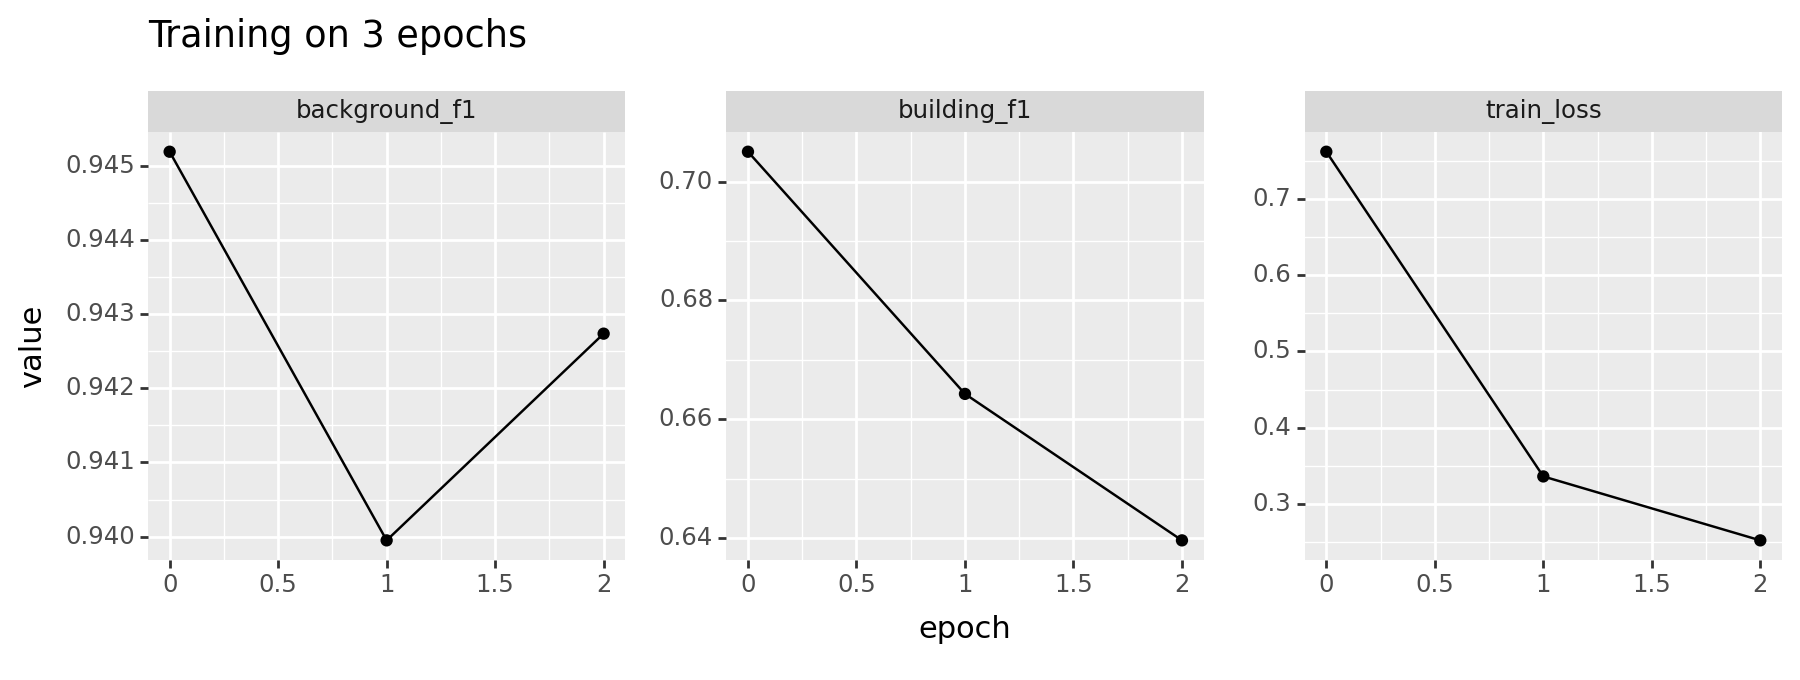

<Figure Size: (900 x 340)>

In [13]:
(pn.ggplot(df_0, pn.aes(x='epoch', y='value'))
    + pn.geom_point()
    + pn.geom_line()
    + pn.facet_wrap('variable', scales='free_y')
    + pn.theme(figure_size=(9, 3.4))
    + pn.ggtitle("Training on 3 epochs")
)

In [14]:
validation_raster = rioxarray.open_rasterio("/project/geospatialworkshop/session_3-dl_rastervision/semantic_segmentation/data/RGB-PanSharpen_AOI_2_Vegas_img25.tif")
validation_vector = gp.read_file("/project/geospatialworkshop/session_3-dl_rastervision/semantic_segmentation/data/buildings_AOI_2_Vegas_img25.geojson")
val_prediction = rioxarray.open_rasterio(temp_dir/"semanticseg_train_0/predict/scene_25/labels.tif")

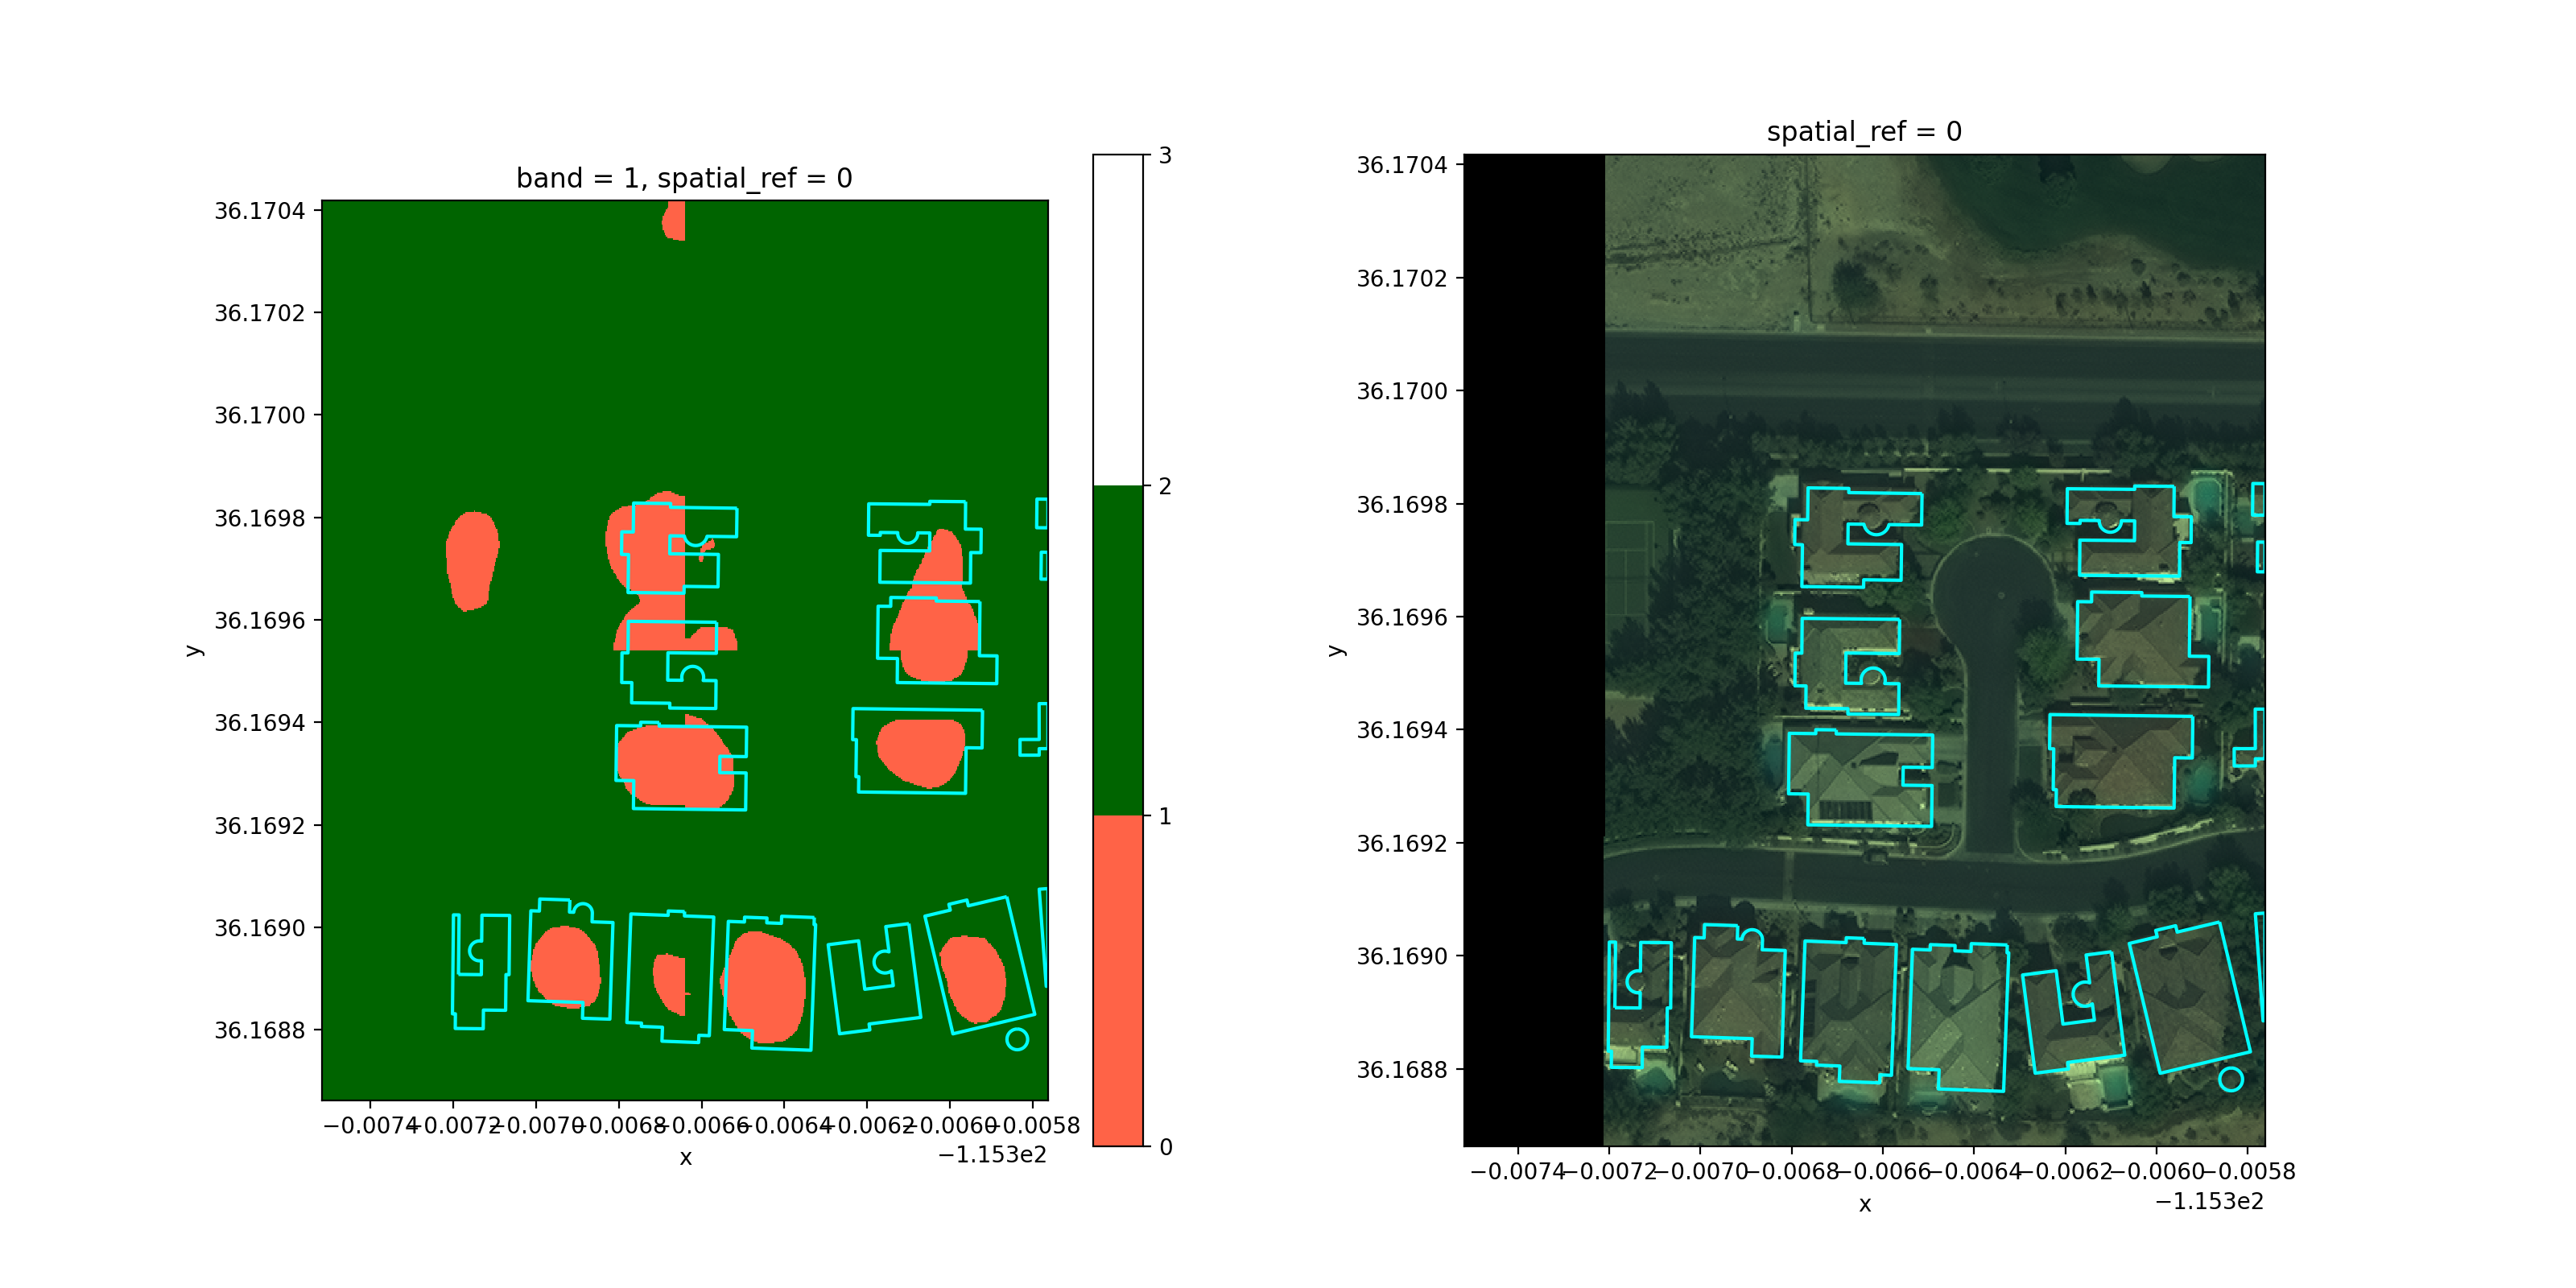

In [15]:
plot_prediction(validation_raster, validation_vector, val_prediction)

In [16]:
# Load the logged metrics values.
df_1 = pd.read_csv(temp_dir / 'semanticseg_train_1/train/log.csv')
df_1

,epoch,train_loss,train_time,val_loss,avg_precision,avg_recall,avg_f1,building_precision,building_recall,building_f1,background_precision,background_recall,background_f1,null_precision,null_recall,null_f1,valid_time
0,0,0.814019,0:00:29.605748,0.615916,0.901430,0.895879,0.898646,0.690243,0.713299,0.701582,0.943925,0.932618,0.938238,0.0,0.0,0.0,0:00:01.332829
1,1,0.500417,0:00:20.185599,0.376361,0.914455,0.918254,0.916350,0.784895,0.661590,0.717987,0.938636,0.966159,0.952199,0.0,0.0,0.0,0:00:01.361030
2,2,0.351359,0:00:20.177405,0.346290,0.919441,0.922658,0.921047,0.808053,0.687810,0.743098,0.941074,0.968267,0.954477,0.0,0.0,0.0,0:00:01.363139
3,3,0.275515,0:00:20.218418,0.326675,0.913176,0.908850,0.911008,0.730935,0.806882,0.767033,0.954809,0.932145,0.943341,0.0,0.0,0.0,0:00:01.390115
4,4,0.259607,0:00:20.209917,0.215385,0.925053,0.928290,0.926669,0.851439,0.644591,0.733715,0.938378,0.979642,0.958566,0.0,0.0,0.0,0:00:01.348871
5,5,0.203603,0:00:20.217061,0.281403,0.915396,0.918320,0.916856,0.806558,0.704771,0.752237,0.938632,0.963911,0.951103,0.0,0.0,0.0,0:00:01.371811
6,6,0.226282,0:00:20.247760,0.190972,0.929618,0.931930,0.930772,0.853272,0.728497,0.785963,0.945428,0.974058,0.959529,0.0,0.0,0.0,0:00:01.401517
7,7,0.173704,0:00:20.254387,0.224781,0.932667,0.928416,0.930537,0.762608,0.853334,0.805424,0.968396,0.944191,0.956140,0.0,0.0,0.0,0:00:01.371068
8,8,0.171681,0:00:20.275737,0.226463,0.928769,0.929369,0.929069,0.809330,0.790642,0.799877,0.954727,0.959518,0.957117,0.0,0.0,0.0,0:00:01.377566
9,9,0.150525,0:00:20.273280,0.193895,0.939278,0.931409,0.935327,0.731996,0.882661,0.800299,0.977506,0.940400,0.958594,0.0,0.0,0.0,0:00:01.383196


In [17]:
# We'll need to reshape this dataframe from wide to long ("tidy") format to use
# it with ggplot.
df_1 = df_1[['epoch', 'train_loss', 'building_f1', 'background_f1']]
df_1 = pd.melt(df_1, id_vars='epoch')

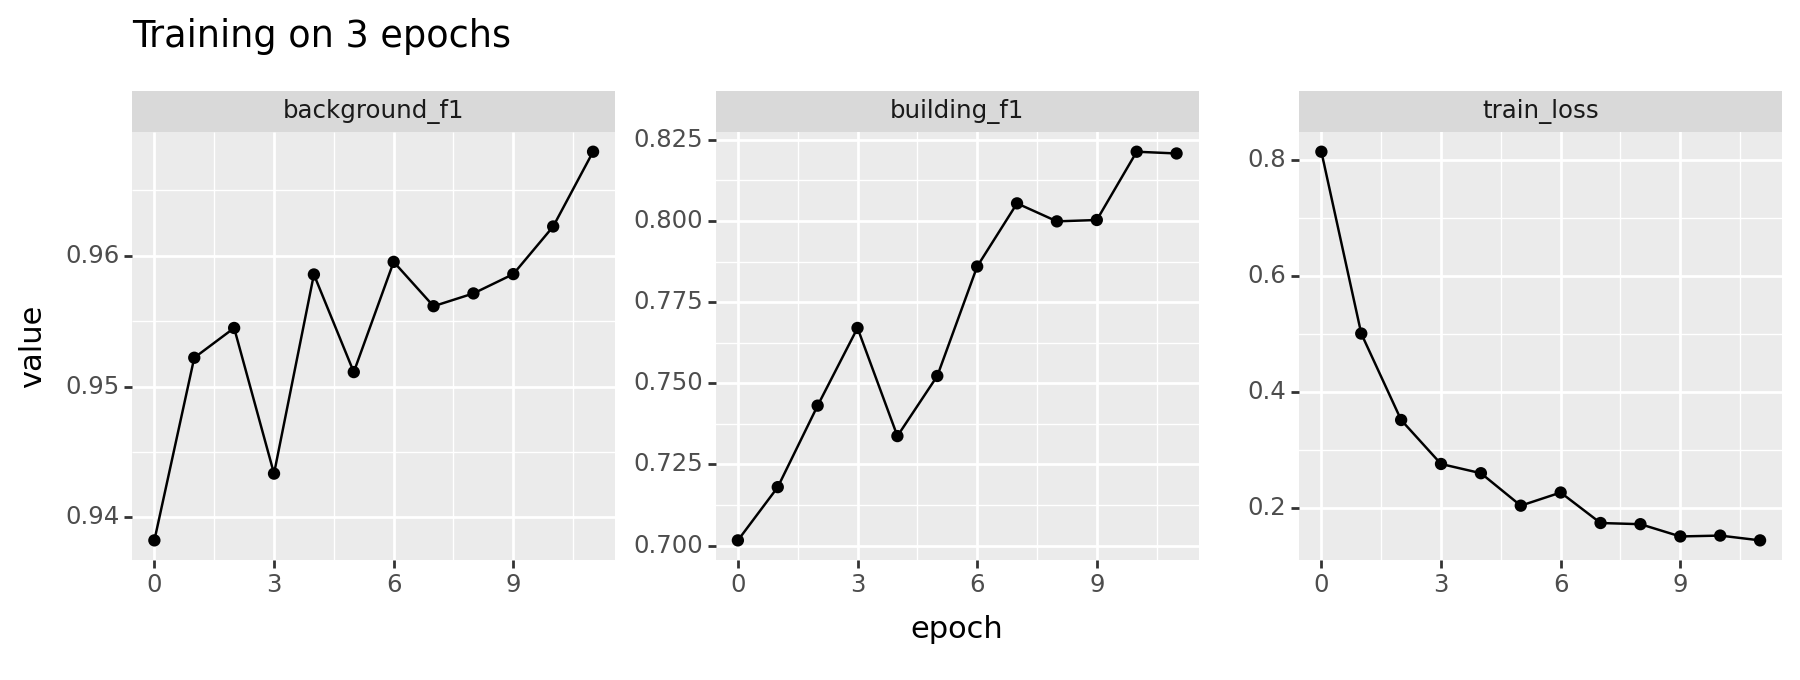

<Figure Size: (900 x 340)>

In [18]:
(pn.ggplot(df_1, pn.aes(x='epoch', y='value'))
    + pn.geom_point()
    + pn.geom_line()
    + pn.facet_wrap('variable', scales='free_y')
    + pn.theme(figure_size=(9, 3.4))
    + pn.ggtitle("Training on 3 epochs")
)

In [19]:
validation_raster = rioxarray.open_rasterio("/project/geospatialworkshop/session_3-dl_rastervision/semantic_segmentation/data/RGB-PanSharpen_AOI_2_Vegas_img25.tif")
validation_vector = gp.read_file("/project/geospatialworkshop/session_3-dl_rastervision/semantic_segmentation/data/buildings_AOI_2_Vegas_img25.geojson")
val_prediction = rioxarray.open_rasterio(temp_dir/"semanticseg_train_1/predict/scene_25/labels.tif")

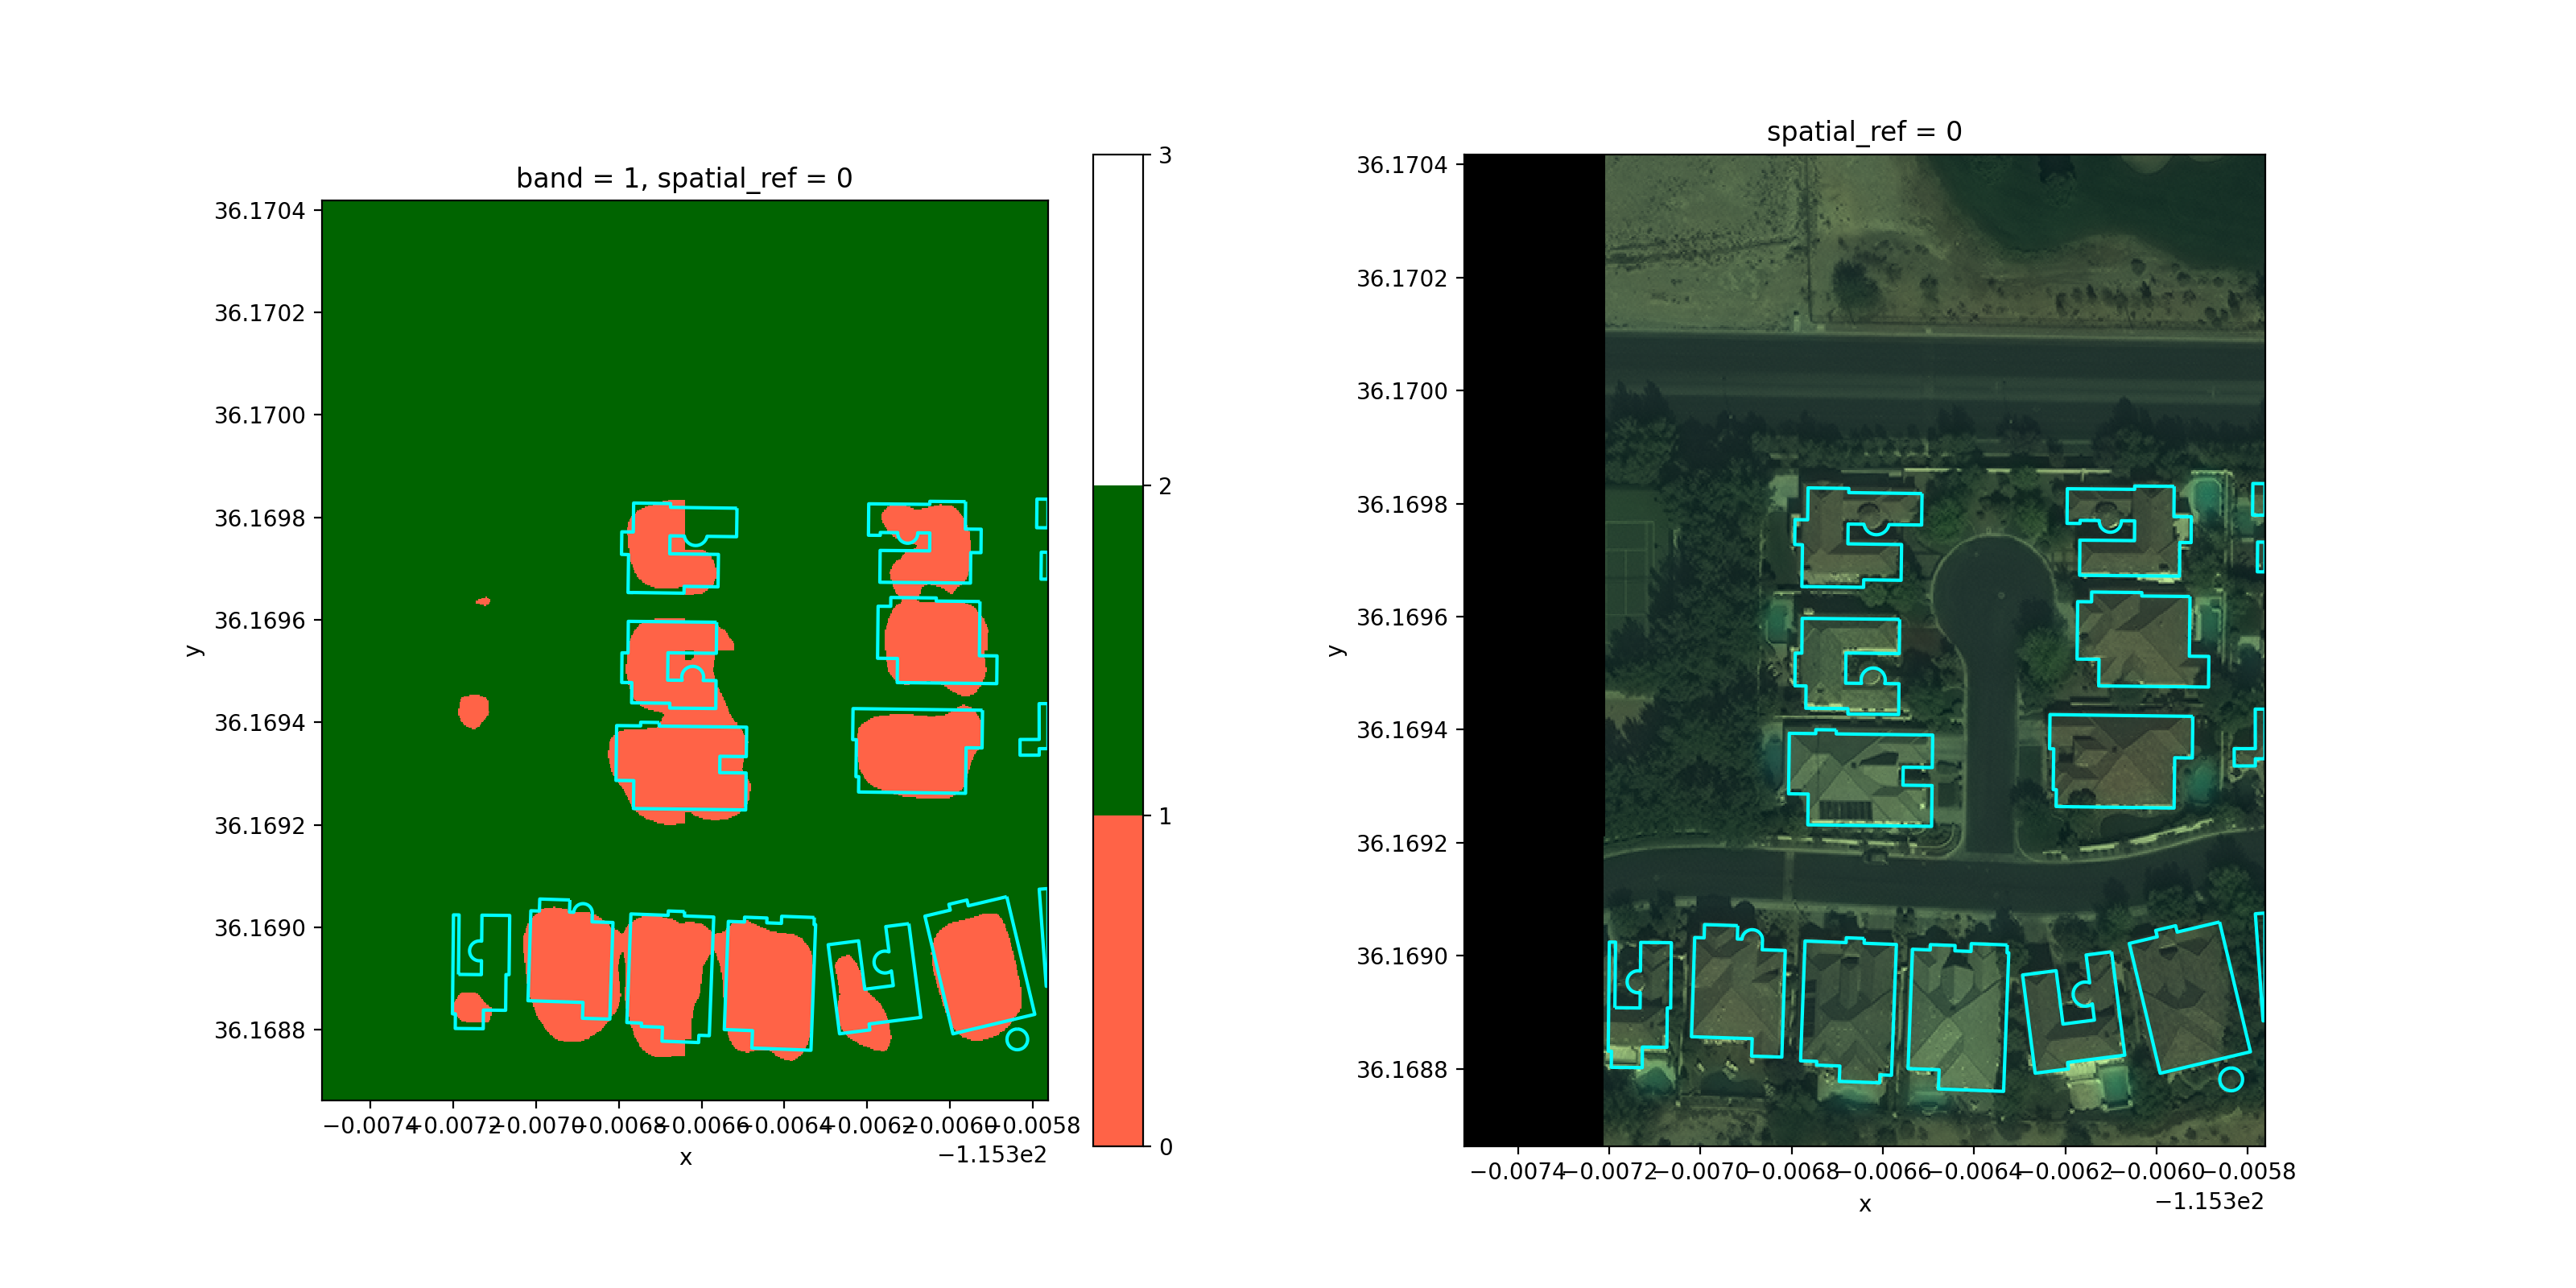

In [20]:
plot_prediction(validation_raster, validation_vector, val_prediction)